# High Frequency Moments of the Green's Functions and Self-energy


We present here the derivation of the high-frequency moments of the Green's function and self-energy, as well as show case how they can be computed and utilized within TRIQS/cthyb.

## Derivation
The following derivation follows closely [Rev. Mod. Phys 83, 349 (2011)](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.83.349) and [Phys. Rev. B 84, 073104 (2011)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.84.073104).

The high-frequency expansion of the Green's function takes the following form 

$$ \mathbf{G}(i\omega_{n}) = \frac{1}{i\omega_{n}}\mathbf{G}_{0} + \frac{1}{(i\omega_{n})^{2}}\mathbf{G}_{1} + \frac{1}{(i\omega_{n})^{3}}\mathbf{G}_{2} + \cdots \ , $$
where the coefficients are related to time derivatives of the Green's function:

$$ \mathbf{G}_{0} = -(G(0) + G(\beta)) = \delta_{ab}$$
$$ \mathbf{G}_{1} = \partial_{\tau}G(0) + \partial_{\tau}G(\beta) = -\langle \{[H, d_{a}], d_{b}^{\dagger} \} \rangle $$
$$ \mathbf{G}_{2} = -\big (\partial^{2}_{\tau}G(0) + \partial^{2}_{\tau}G(\beta) \big ) = \langle \{[H, d_{a}], [d_{b}^{\dagger},H] \} \rangle \ , $$
where $H$ is the Hamiltonian of the system. For the purpose of this cthyb tutorial we assume $H$ to be the general Anderson impurity hamiltonian, 

$$H = \sum_{k,\alpha} \varepsilon_{k\alpha}c^{\dagger}_{k\alpha}c_{k\alpha} + \sum_{k\alpha b} \big ( V_{k}^{\alpha b} c^{\dagger}_{k\alpha}d_{b} + \mathrm{h.c.}\big ) + \sum_{ab}E_{ab}d^{\dagger}_{a}d_{b} + \frac{1}{2}\sum_{abcd}U_{abcd}d^{\dagger}_{a}d^{\dagger}_{b}d_{d}d_{c} \ .$$

In DMFT the coefficients for the Weiss field $\mathcal{G}_{0}$ can be obtained from the same expressions as the Green's function with the hamiltonian replaced with only the non-interacting part. 

To derive the analogous coefficients for the self-energy, we start with the Dyson equation,

$$\mathbf{\Sigma} = \Big ((\mathcal{G}_{0} )^{-1} - \mathbf{G}^{-1} \Big ) \ .$$

Using the high-frequency expression for the Green's function and Weiss field we obtain,

$$ \mathbf{\Sigma} = \frac{1}{\frac{1}{i\omega_{n}} + \frac{1}{(i\omega_{n})^{2}}(\mathbf{G}_{0})_{1} + \frac{1}{(i\omega_{n})^{3}} (\mathbf{G}_{0})_{2}}-\frac{1}{\frac{1}{i\omega_{n}} + \frac{1}{(i\omega_{n})^{2}}\mathbf{G}_{1} + \frac{1}{(i\omega_{n})^{3}} \mathbf{G}_{2}} \ .$$

Expanding this expression for large $i\omega_{n}$ and simplifying yields,

$$\mathbf{\Sigma} = \Big (\mathbf{G}_{1} - (\mathcal{G}_{0})_{1} \Big ) + \frac{1}{i\omega_{n}} \Big (\mathbf{G}_{2} - (\mathcal{G}_{0})_{2} +((\mathcal{G}_{0})_{1})^{2} - \mathcal{G}_{1}^{2} \Big) + \mathcal{O}\Big ( (i\omega_{n})^{-2}\Big )$$

We now identify the leading terms,

$$ \mathbf{\Sigma}_{\infty} \equiv \mathbf{G}_{1} - (\mathcal{G}_{0})_{1} $$
$$ \mathbf{\Sigma}_{1} \equiv \mathbf{G}_{2} - (\mathcal{G}_{0})_{2} +((\mathcal{G}_{0})_{1})^{2} - \mathbf{G}_{1}^{2} $$

Note, that $(\mathcal{G}_{0})_{1}$ are just the crystal field levels inside of the impurity problem $\mathbf{E}$. We can simplify these expressions by plugging in their definitions from above,

$$\Sigma_{\infty}^{ab} = -\langle \{[H, d_{a}], d_{b}^{\dagger} \} \rangle + \langle \{[H-H_{\mathrm{int}}, d_{a}], d_{b}^{\dagger} \} \rangle  = - \langle \{[H_{\mathrm{int}}, d_{a}], d_{b}^{\dagger} \} \rangle $$

$$\Sigma_{1}^{ab} = \langle \{ [H_{\mathrm{int}}, [H_{\mathrm{int}}, d_{a} ]], d_{b}^\dagger \} \rangle - (\Sigma_{\infty}^{ab} )^{2} $$


## Implentation in TRIQS/cthyb

The leading two moments of $\mathbf{G}$ and of $\mathbf{\Sigma}$ are automatically calculated and stored as members of the TRIQS/cthyb solver when ``measure_density_matrix = True``. The moments for the Green's function and self-energy are stored as ``Solver.G_moments`` and ``Solver.Sigma_moments``, with the matching block structure of the ``Gf`` objects. Additionally, the Hartree shift $\mathbf{\Sigma}^\infty$ is stored as ``Solver.Sigma_Hartree``.

The moments of the Green's function are used in the Fourier transform of $G(\tau)$ to $G(i\omega_{n})$ in the solver post-processing automatically if available. The moments of the self-energy are used in the tail fitting routine, where the first two ``known_moments`` now correspond to the calculated first and second moments of the self-energy.

In [1]:
from triqs.gf import *
from triqs.operators import *
from triqs_cthyb import Solver
import triqs.utility.mpi as mpi

import numpy as np
from triqs.plot.mpl_interface import plt,oplot

Starting serial run at: 2023-01-31 16:48:21.624802


In [2]:
D, V, U = 1.0, 0.2, 4.0

ef, beta = -U/2.0, 50
H = U*n('up',0)*n('down',0)
S = Solver(beta=beta, gf_struct=[('up',1), ('down', 1)])

for name, g0 in S.G0_iw: g0 << inverse(iOmega_n - ef - V**2 * Wilson(D))

S.solve(h_int = H,
                n_cycles =500000,
                length_cycle = 200,
                n_warmup_cycles = 100000,
                measure_density_matrix=True, # moments will be calculated automatically
                use_norm_as_weight = True,
                )


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-2*c_dag('down',0)*c('down',0) + -2*c_dag('up',0)*c('up',0) + 4*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
16:48:23   0% ETA 00:00:10 cycle 904 of 100000
16:48:25  22% ETA 00:00:07 cycle 22268 of 100000
16:48:28  49% ETA 00:00:04 cycle 49027 of 100000
16:48:31  82% ETA 00:00:01 cycle 82463 of 100000
16:48:32 100% ETA 00:00:00 cycle 99999 of 100000



Accumulating ...
16:48:32   0% ETA 00:00:47 cycle 1040 of 500000
16:48:34   4% ETA 00:00:45 cycle 22176 of 500000
16:48:37   9% ETA 00:00:43 cycle 48636 of 500000
16:48:40  16% ETA 00:00:40 cycle 81598 of 500000
16:48:44  24% ETA 00:00:36 cycle 122877 of 500000
16:48:49  34% ETA 00:00:31 cycle 174367 of 500000
16:48:55  47% ETA 00:00:25 cycle 238912 of 500000
16:49:03  63% ETA 00:00:17 cycle 31936

Here, we can compare the high-frequency expansion of the self-energy to the real and imaginary parts of the self-energy obtained from the Dyson equation using the sampled Green's function and input Weiss field. The real part corresponds to the overall Hartree shift and the imaginary part captures the correct high-frequency tail behavior. First, let's have a look at the calculated moments:

In [3]:
for block, moment in S.Sigma_moments.items():
    print('-------')
    print(f'{block}:')
    for i, value in enumerate(moment):
        print(f'𝚺_{i}= {value[0,0].real:1.4f}')

-------
up:
𝚺_0= 2.0033
𝚺_1= 4.0000
-------
down:
𝚺_0= 1.9967
𝚺_1= 4.0000


In [4]:
for block, moment in S.G_moments.items():
    print('-------')
    print(f'{block}:')
    for i, value in enumerate(moment):
        print(f'Gimp_{i}= {value[0,0].real:1.4f}')

-------
up:
Gimp_0= 0.0000
Gimp_1= 1.0000
Gimp_2= 0.0033
-------
down:
Gimp_0= 0.0000
Gimp_1= 1.0000
Gimp_2= -0.0033


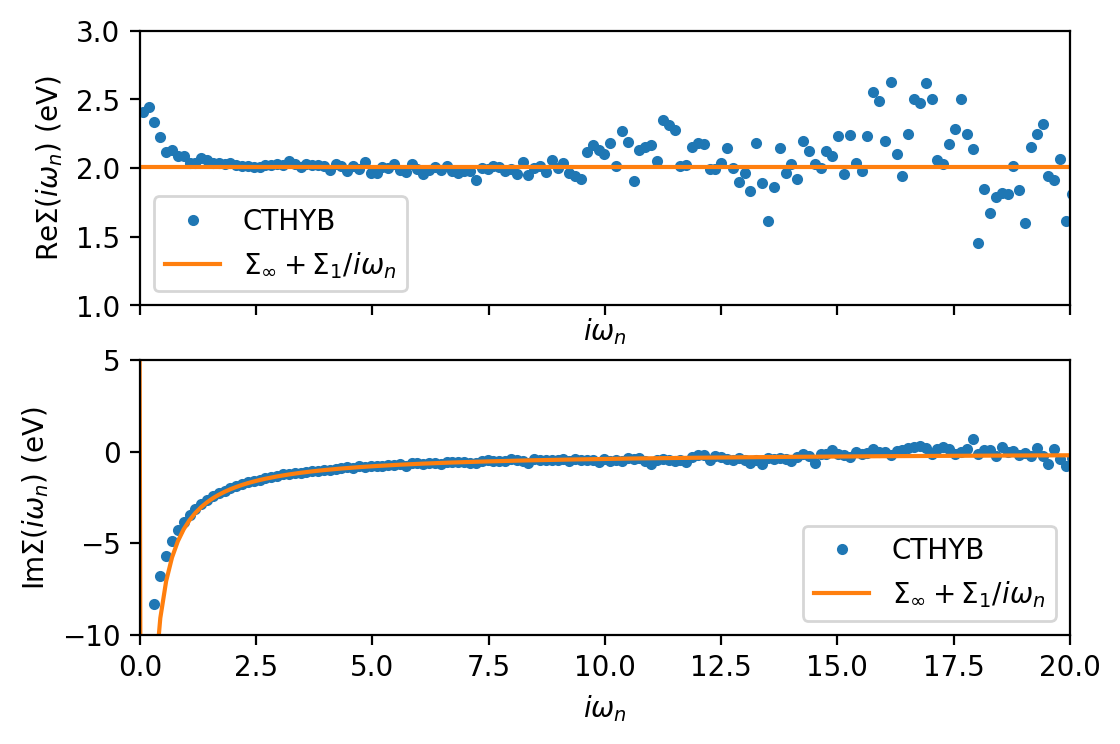

In [5]:
fig, ax = plt.subplots(2,1, sharex=True, dpi=200)

# prepare highfreq expansion for plotting on grid
iwn = np.array([complex(x) for x in S.Sigma_iw.mesh])
high_freq = S.Sigma_moments['up'][0][0,0] + S.Sigma_moments['up'][1][0,0]/iwn

# plot Re component
ax[0].oplot(S.Sigma_iw['up'][0,0].real, 'o', ms=3, label='CTHYB')
ax[0].plot(iwn.imag, high_freq.real, '-', label=r'$\Sigma_{\infty} + \Sigma_{1}/i\omega_{n}$')

# plot Im component
ax[1].oplot(S.Sigma_iw['up'][0,0].imag, 'o', ms=3, label='CTHYB')
ax[1].plot(iwn.imag, high_freq.imag, '-', label=r'$\Sigma_{\infty} + \Sigma_{1}/i\omega_{n}$')

ax[0].legend(); ax[1].legend()
ax[0].set_xlabel(r'$i\omega_{n}$'); 
ax[1].set_xlabel(r'$i\omega_{n}$'); 
ax[0].set_ylabel(r'Re$\Sigma(i\omega_{n})$ (eV)')
ax[1].set_ylabel(r'Im$\Sigma(i\omega_{n})$ (eV)')
ax[0].set_xlim(0, 20);
ax[0].set_ylim(1,3); ax[1].set_ylim(-10, 5)
plt.subplots_adjust(wspace=0.5)
plt.show()

Additionally, we can verify the relationship between the first moment of the Green's function and first moment of the self-energy,
$$ \mathbf{\Sigma}_{\infty} = \mathbf{G}_{1} - (\mathcal{G}_{0})_{1}$$
$$ \mathbf{\Sigma}_{\infty} = \mathbf{G}_{1} - \mathbf{E}, $$
where $\mathbf{E}$ are the local impurity levels.

In [6]:
E = {key[-1][1][0] : coef for key, coef in S.h_loc0}
print((S.Sigma_moments['up'][0] - S.G_moments['up'][-1] + E['up'])[0,0].real)

-2.3092638912203256e-14


Hence, the above equation holds exactly up to machine precision!